**The Battle of the Neighborhoods: Caribbean Edition**

**Introduction & Business Problem :**

**Problem Background:**

The City of New York, is the most famous and vibrant city in the United States.It is seen as a melting pot of cultures which means that is it likely to also be a melting pot for food. With this popularity it provides an enabling environment for buinesses of various types. New York City was home to nearly 8.5 million people in 2018, accounting for over 40% of the population of New York State and a slightly lower percentage of the New York metropolitan area, home to approximately 23.6 million. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States, which is why the focus of this project will be on Caribbean immigrants who want to open up a restaurant. This final project explores the best locations for Caribbean restaurants throughout the city of New York.

**Problem Statement**

What is / are the best location(s) for Caribbean cuisine in New York City?
In what Neighborhood and/or borough should the investor open a Caribbean restaurant to have the best chance of being successful?
Where would I go in New York City to have the best Caribbean food?

**Data**

Data on New York City neighborhoods, boroughs, and their respective latitudes & longitudes, as well as the restaurant ratings and tips are required.

New York City location data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

All data related to locations and quality of Caribbean restaurants will be obtained via the FourSquare API utilized via the Request library in Python

**Methodology**

• Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.

• FourSquare be used to locate all venues and then filtered by Caribbean restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.

• Data will be sorted based on rankings.

• Finally, the data will be visually assessed using graphing from Python libraries.

In [1]:
#Import Libraries

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    ------------------------------------------------------------
                       

In [2]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'OYOPB2LPRCK4LL1DAY1VSAQ0MPTLCUK1U1KW0GRSZ1WHYPS4' # your Foursquare ID
CLIENT_SECRET = 'G5IIFDKPPL350U2F5G3XXXNBH4AIFL1JO5IG4CKNGRKYUR2U' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [3]:
#Define the functions for the project

def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [4]:
# Get NY Location Data

ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
# Dimensions of the Data
ny_data.shape

(306, 4)

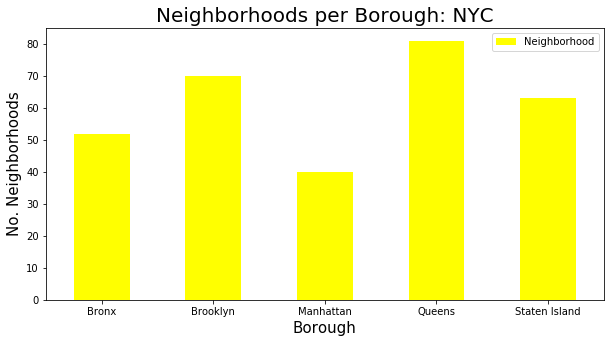

In [6]:
#Initial Data Analysis of Boroughs
clr = "yellow"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()


In [13]:
# Identifying the number of Jamaican restaurants in each neighbourhood

# queens has most neighborhoods
# prepare neighborhood list that contains Caribbean restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
car_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    car_restaurants=venues[venues['Category']=='Caribbean Restaurant']   
    print('(',count,'/',len(ny_data),')','Caribbean Restaurants in '+Neighborhood+', '+Borough+':'+str(len(jam_restaurants)))
    print(row)
    for resturant_detail in car_restaurants.values.tolist():
        id, name , category=resturant_detail
        car_rest_ny = car_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)

( 1 / 306 ) Caribbean Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 1 / 306 ) Caribbean Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 1 / 306 ) Caribbean Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 1 / 306 ) Caribbean Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 1 / 306 ) Caribbean Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 1 / 306 ) Caribbean Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 1 / 306 ) Caribbean Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 1 / 306 ) Caribbean Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 1 / 306 ) Caribbean Restaurants in N

In [15]:
# Save the info toa CSV File due to limited calls

car_rest_ny.to_csv('car_rest_ny_tocsv1.csv')


In [16]:
# Read CSV into Pandas Dataframe

car_ny = pd.read_csv('car_rest_ny_tocsv1.csv')
car_rest_ny.tail()

,Borough,Neighborhood,ID,Name
55,Brooklyn,Weeksville,559b55c3498e21cd6d72e195,Irie Caribbean Kitchen & Bakery
56,Brooklyn,Broadway Junction,4e42a587aeb79367c7e9f663,Golden Krust Caribbean Restaurant
57,Brooklyn,Erasmus,4b53503bf964a520d29627e3,Exquisite Delight
58,Brooklyn,Erasmus,4d95f915e07ea35d0f03b402,Trini Breakfast Shed II
59,Brooklyn,Erasmus,4b66446af964a520621b2be3,Golden Krust Caribbean Restaurant


In [17]:
# How many Caribbean restaurants exist in NY?
car_rest_ny.shape

(60, 4)

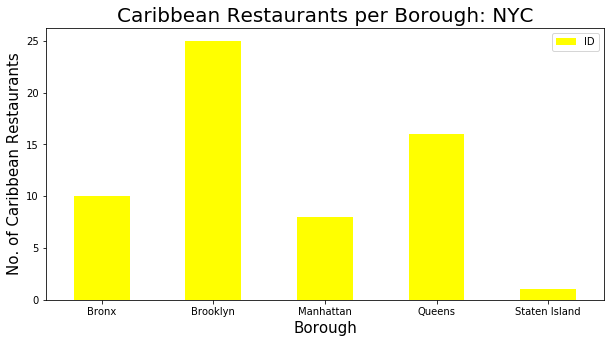

In [18]:
# We somehow managed to find some Caribbean Restaurants: Display them by Borough

car_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Caribbean Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Caribbean Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

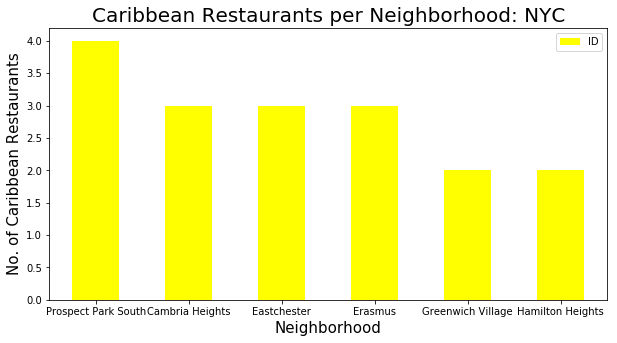

In [19]:
# Brooklyn had the most Caribbean Restaurants, break it down by neighbourhood

NOofNeigh = 6 # top number for graphing all the same past 6
car_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Caribbean Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Caribbean Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [22]:
# Prospect Park is located in Brooklyn, lets look at these restaurants

car_rest_ny[car_rest_ny['Neighborhood']=='Prospect Park South']


,Borough,Neighborhood,ID,Name
20,Brooklyn,Prospect Park South,57597fd8498e2922f0ff1b22,Island Express
21,Brooklyn,Prospect Park South,4cb8984bbac937044c4fde7c,Golden Krust Caribbean Restaurant
22,Brooklyn,Prospect Park South,4f21c4c4e5e872143c0d843b,Golden Krust Caribbean Bakery and Grill
23,Brooklyn,Prospect Park South,5a65220523a2e62015a22275,Tastee Pattee


In [23]:
# Lets look at the ranking of restaurants in Prospect Park for further insight

column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
car_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in car_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(car_rest_ny),')','processed')
    car_rest_stats_ny = car_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
car_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5f3cad67be770f153be09a4d'}, 'response': {'venue': {'id': '515cc20ce4b0deb133b8e89b', 'name': 'Fish & Ting', 'contact': {'phone': '7188816116', 'formattedPhone': '(718) 881-6116'}, 'location': {'address': '4063 Boston Rd', 'crossStreet': 'Conner St', 'lat': 40.885656, 'lng': -73.829197, 'labeledLatLngs': [{'label': 'display', 'lat': 40.885656, 'lng': -73.829197}, {'label': 'entrance', 'lat': 40.885608, 'lng': -73.829175}], 'postalCode': '10466', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4063 Boston Rd (Conner St)', 'Bronx, NY 10466', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fish--ting/515cc20ce4b0deb133b8e89b', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '.png'}, 'primary': True}], 'verified':

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
55,Brooklyn,Weeksville,0,0,0,0.0,0
56,Brooklyn,Broadway Junction,4e42a587aeb79367c7e9f663,Golden Krust Caribbean Restaurant,5,6.8,2
57,Brooklyn,Erasmus,4b53503bf964a520d29627e3,Exquisite Delight,52,8.7,16
58,Brooklyn,Erasmus,4d95f915e07ea35d0f03b402,Trini Breakfast Shed II,20,6.9,12
59,Brooklyn,Erasmus,4b66446af964a520621b2be3,Golden Krust Caribbean Restaurant,3,6.7,4


In [24]:
#Append and Save data

car_rest_stats_ny.to_csv('car_rest_stats_ny_csv.csv')

In [25]:
# Shape of newly saved data

car_rest_stats_ny.shape

(60, 7)

In [26]:
#Check data types

car_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 7 columns):
Borough         60 non-null object
Neighborhood    60 non-null object
ID              60 non-null object
Name            60 non-null object
Likes           60 non-null object
Rating          60 non-null float64
Tips            60 non-null object
dtypes: float64(1), object(6)
memory usage: 3.4+ KB


In [28]:
# Convert Data to floats from strings

car_rest_stats_ny['Likes'] = car_rest_stats_ny['Likes'].astype('float64')
car_rest_stats_ny['Tips'] = car_rest_stats_ny['Tips'].astype('float64')
car_rest_stats_ny.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 7 columns):
Borough         60 non-null object
Neighborhood    60 non-null object
ID              60 non-null object
Name            60 non-null object
Likes           60 non-null float64
Rating          60 non-null float64
Tips            60 non-null float64
dtypes: float64(3), object(4)
memory usage: 3.4+ KB


In [29]:
# Descriptive Statistics of Dataset

car_rest_stats_ny.describe()


,Likes,Rating,Tips
count,60.000000,60.000000,60.000000
mean,48.116667,6.361667,18.116667
std,149.639124,2.678609,51.905746
min,0.000000,0.000000,0.000000
25%,3.000000,6.175000,1.000000
50%,10.000000,6.900000,4.000000
75%,24.250000,7.925000,12.250000
max,970.000000,9.300000,345.000000


In [30]:
# Analysis of Restaurants: Resturant with most Likes
car_rest_stats_ny.iloc[car_rest_stats_ny['Likes'].idxmax()]

Borough                                Manhattan
Neighborhood                   Greenwich Village
ID                      4d9e8aa89b91a1cdc7c958c0
Name            Miss Lily's & Melvin's Juice Box
Likes                                        970
Rating                                         9
Tips                                         345
Name: 31, dtype: object

In [31]:
# Analysis of Restaurants: Resturant with the best ratings
car_rest_stats_ny.iloc[car_rest_stats_ny['Rating'].idxmax()]



Borough                         Brooklyn
Neighborhood            Prospect Heights
ID              5a4d750e3fcee83d3f3ce36c
Name                         The Islands
Likes                                 57
Rating                               9.3
Tips                                  15
Name: 12, dtype: object

In [32]:
# Analysis of Restaurants: Resturant with best Tips
car_rest_stats_ny.iloc[car_rest_stats_ny['Tips'].idxmax()]

Borough                                Manhattan
Neighborhood                   Greenwich Village
ID                      4d9e8aa89b91a1cdc7c958c0
Name            Miss Lily's & Melvin's Juice Box
Likes                                        970
Rating                                         9
Tips                                         345
Name: 31, dtype: object

In [33]:
#Identify the neighborhood with the best average rating of restaurants

ny_neighborhood_stats=car_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
28,Prospect Heights,9.30
11,East Village,9.10
19,Greenwich Village,8.95
18,Fort Greene,8.70
24,Kingsbridge,8.60
16,Flatlands,8.30
23,Jamaica Hills,8.20
40,Washington Heights,8.10
20,Hamilton Heights,8.10
10,East Flatbush,7.90


In [34]:
# Identify the borough with the best average rating of restaurants 
ny_borough_stats=car_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,7.33750
0,Bronx,7.05000
1,Brooklyn,6.15600
4,Staten Island,5.90000
3,Queens,5.79375


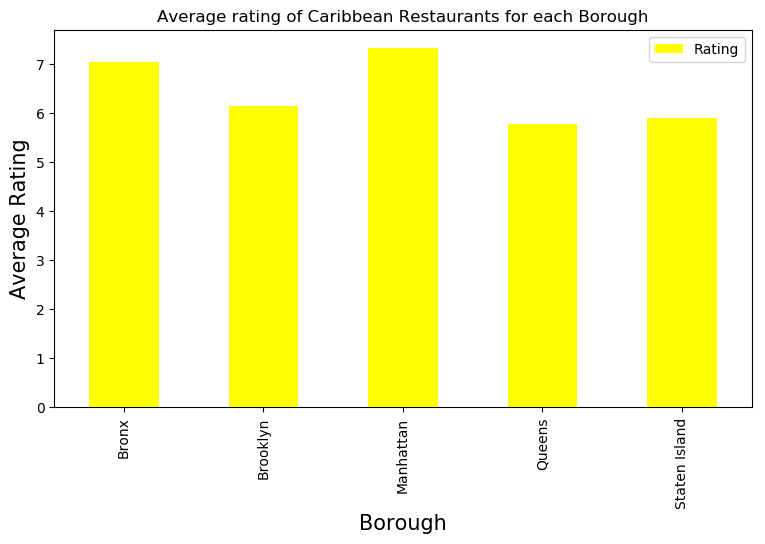

In [35]:
# Visualization of the borough with the best average rating of restaurants 

plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Caribbean Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
car_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()


In [36]:
# Create Average Rating for Visualization

ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=6.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Broadway Junction,6.800000
2,Central Harlem,7.400000
3,Claremont Village,6.700000
4,Clinton Hill,7.100000
5,College Point,6.500000
6,Concourse,6.600000
9,Downtown,7.500000
10,East Flatbush,7.900000
11,East Village,9.100000
12,Eastchester,7.200000


In [37]:
# Append Average rating to original data for location stats
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats


,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Broadway Junction,40.677861,-73.903317,6.800000
1,Manhattan,Central Harlem,40.815976,-73.943211,7.400000
2,Bronx,Claremont Village,40.831428,-73.901199,6.700000
3,Brooklyn,Clinton Hill,40.693229,-73.967843,7.100000
4,Queens,College Point,40.784903,-73.843045,6.500000
5,Bronx,Concourse,40.834284,-73.915589,6.600000
6,Brooklyn,Downtown,40.690844,-73.983463,7.500000
7,Brooklyn,East Flatbush,40.641718,-73.936103,7.900000
8,Manhattan,East Village,40.727847,-73.982226,9.100000
9,Bronx,Eastchester,40.887556,-73.827806,7.200000


In [48]:
# Visualization of Neighbourhood Ratings

# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=20)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='green',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )


In [49]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

**Results / Conclusion**

Manhattan and Bronx have the best rated Caribbean restaurants on average. Staten Island and Manhattan have the least amount of Caribbean Restaurants restaurants per borough while Brooklyn and Queens have the most. Prospect Park South in Brooklyn has the highest number of Caribbean Restaurants in all of NY. Brooklyn and Queens have the highest number of neighbourhoods in NYC. Staten Island despite having average ratings, it has a high number of neighbourhoods and the lowest number of Caribbean Restaurants which means that competition isnt fierce and business can be distirbuted.To have the best shot of success, I would open a Caribbean restaurant in Staten island. As a final note, all of the above analysis is depended on the accuracy of Four Square data. A more comprehensive analysis and future work would need to incorporate data from other external databases.